In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

## Thrust Data

In [7]:
thrustFromFile = np.genfromtxt('./k1103x.csv',delimiter=',')

In [10]:
thrustFromFile[0,0] = 0.012

In [11]:
thrust = np.insert(thrustFromFile,0,[0,0],axis=0)

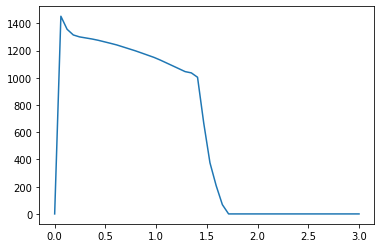

In [12]:
plt.plot(np.linspace(0,3),np.interp(np.linspace(0,3),thrust[:,0],thrust[:,1]));

In [83]:
#returns thrust force given a certain time in Newtons (N)
def thrustFunc(t):
    return 1.04*np.interp(t,thrust[:,0],thrust[:,1])

burnoutTime = 2.5
def massFunc(t):
    if(t<burnoutTime):
        return 6.44+1.46*(1-t/burnoutTime)
    else:
        return 6.44

#BAAAADDDD
#Please do better
def dragCoeffFunc(totalVel):
    return .541
#     if(totalVel<45):
#         return .435-(.435-.335)/45*totalVel
#     else:
#         return (.335*(210-totalVel)+.422*(totalVel-45))/(210-45)
    
    
#returns an approximation for the density of air at a given altitutde
def rho(altitude):
    rho0 = 1.225 #kg/m^3
    Hn = 10.4*10**3 #meters
    return rho0*np.exp(-altitude/Hn)

## Simulation settings

In [84]:
dt=0.001
tInitial = 0
tFinal = 100
time = np.arange(tInitial,tFinal,dt)

In [85]:
mass = 6.44 #kg
gravityForce = np.array([0,0,-9.81])*mass
Area = np.pi/4.0*(.102)**2
parachuteDragCoefficient = 10

In [86]:
#given the rockets position, velocity, drag Coefficient, and time, return how the velocity and position change
def derivative(position, velocity,dragCoefficient, t):
    #determine which way the rocket is pointing
    direction = velocity/(np.linalg.norm(velocity)+10**-9)
    
    #if on rail, launch angle is set
    if(position[2]<1):
        direction = np.array([0,np.sin(0.0873),np.cos(0.0873)])
    
    #wind force - random gusts of wind pushing the rocket on the way up
    #wind mostly blows side to side and not up and down (I think?)
    windforce = windFunc(t)*np.array([rand.normal(loc=1,scale=windxStdDev),rand.normal(loc=1,scale=windyStdDev),rand.normal(loc=windzRatio,scale=windzStdDev)])
    
    sumForces = gravityForce + (thrustFunc(t) - 1/2*Area*rho(position[2])*np.linalg.norm(velocity)**2*dragCoefficient)*direction+windforce
    
    return [sumForces/massFunc(t),velocity + sumForces/massFunc(t)*dt]
    
#function to perform integration step
#helpful to change out integration under the hood without needing to clutter main loop
def quadrature(position,velocity,dragCoefficient, t):
    
    #Heun's method
#     motion = derivative(position, velocity, dragCoefficient,t)
#     velocityGuess = velocity + motion[0]*dt
#     positionGuess = position + motion[1]*dt
    
#     motionUpdate = derivative(positionGuess,velocityGuess,dragCoefficient,t+dt)
    
#     velocityNext = velocity + dt/2*(motion[0]+motionUpdate[0])
#     positionNext = position + dt/2*(motion[1]+motionUpdate[1]) 
#     accelerationCurrent = 1/2*(motion[0]+motionUpdate[0])

    #Runge-Kutta method
    k1 = derivative(position, velocity, dragCoefficient,t)
    k2 = derivative(position + dt*k1[1]/2,velocity + dt*k1[0]/2,dragCoefficient,t+dt/2)
    k3 = derivative(position + dt*k2[1]/2,velocity + dt*k2[0]/2,dragCoefficient,t+dt/2)
    k4 = derivative(position + dt*k3[1],velocity + dt*k3[0],dragCoefficient,t+dt)
    
    velocityNext = velocity + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    positionNext = position + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])
    accelerationCurrent = 1/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    
    return positionNext, velocityNext, accelerationCurrent

## VLT

In [87]:
initialVel = 270
targetAlt = 1560.576
def velocityProfile(alt):
    return initialVel/np.sqrt(targetAlt)*np.sqrt(targetAlt-alt)

altitudes = np.linspace(0,targetAlt,100)

velocityLookupTableBase = np.array([altitudes,velocityProfile(altitudes)])
velocityLookupTable = np.transpose(np.genfromtxt('./DragVLT.csv',delimiter=','))
velocityLookupTable[1,-1] = 0
accelLookupTable = np.transpose(np.genfromtxt('./ALT.csv',delimiter=','))

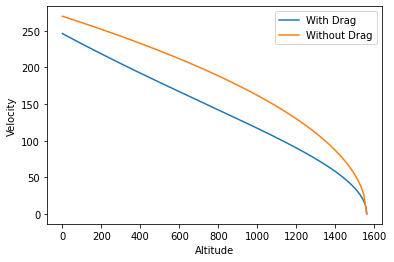

In [88]:
plt.plot(velocityLookupTable[0],velocityLookupTable[1]);
plt.plot(velocityLookupTableBase[0],velocityLookupTableBase[1]);
plt.legend(['With Drag','Without Drag']);
plt.xlabel('Altitude');
plt.ylabel('Velocity');

## Wind Settings

In [89]:
#function that kinda simulates random winds on the way up
def windFunc(time):
    return 3*(np.sin(time/2)+np.cos(time/20))

windxStdDev = .5
windyStdDev = .5
windzStdDev = .5
#ratio of z wind to xy wind
windzRatio = .5

## Controller Settings

In [109]:
controlFrequency= 20 #Hz
controldt = 1/controlFrequency
controlTicks = int(controldt//dt) #in number of ticks (if dt = 0.001, then this represents ms)
rocketDrag = 0.541
airbrakesMaxDrag = 0.25

def errorDecayFunc(alt):
    errorDecayTable = np.array([[targetAlt/4, targetAlt/2,7/8*targetAlt, 2*targetAlt],
                                [     40    ,   20      ,    10,           0]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((errorDecayTable[0]-alt)>0)
    return errorDecayTable[1,index]

def getMaxError(alt):
    maxErrorTable = np.array([[2/8*targetAlt,6/8*targetAlt, 2*targetAlt],
                                [    30      ,    10,           3]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((maxErrorTable[0]-alt)>0)
    return maxErrorTable[1,index]

def calculateError(position,velocity):
    altitude = position[2]
    velocityError = velocity[2] - float(np.interp(altitude, velocityLookupTable[0],velocityLookupTable[1]))
    return velocityError

def calculateAccelError(position,acceleration):
    altitude = position[2]
    accelerationError = acceleration[2] - np.interp(altitude, accelLookupTable[0],accelLookupTable[1])
    return accelerationError

## Airbrake Deployment

In [110]:
secondsPerDegree = 1/2*0.09/60 #number of seconds per degree 

def angleToDrag(profile):
    return profile/90*airbrakesMaxDrag

def deploymentProfile(currentDegrees, TargetDegrees):
    if currentDegrees < TargetDegrees:
        profile = np.linspace(currentDegrees,currentDegrees+controlTicks*dt/secondsPerDegree,num=controlTicks+1)
        profile[profile>TargetDegrees]=TargetDegrees
    else:
        profile = np.linspace(currentDegrees,currentDegrees-controlTicks*dt/secondsPerDegree,num=controlTicks+1)
        profile[profile<TargetDegrees]=TargetDegrees
    return profile

## Kalman Filter settings

In [111]:
#kalman step size
sampleFrequency = 100 #Hz
kdt = 1/sampleFrequency
#for loop
kalmanTicks = int(kdt//dt)

#state Vector
#X = [[x],[y],[z],[vx],[vy],[vz],[ax],[ay],[az]]

#state transition matrix
Fkalman = np.array([[1,0,0,kdt,  0,  0,1/2*kdt**2,         0,         0],
                    [0,1,0,  0,kdt,  0,         0,1/2*kdt**2,         0],
                    [0,0,1,  0,  0,kdt,         0,         0,1/2*kdt**2],
                    [0,0,0,  1,  0,  0,       kdt,         0,         0],
                    [0,0,0,  0,  1,  0,         0,       kdt,         0],
                    [0,0,0,  0,  0,  1,         0,         0,       kdt],
                    [0,0,0,  0,  0,  0,         1,         0,         0],
                    [0,0,0,  0,  0,  0,         0,         1,         0],
                    [0,0,0,  0,  0,  0,         0,         0,         1]])

#Input translation matrix
#take input accelerations from rocket thrust and turn that into state matrix adjustment
Gkalman = np.array([[1/2*kdt**2,0,0],
                    [0,1/2*kdt**2,0],
                    [0,0,1/2*kdt**2],
                    [kdt,0,0],
                    [0,kdt,0],
                    [0,0,kdt],
                    [1,0,0],
                    [0,1,0],
                    [0,0,1]])

#observation model
#converts state vector to equivalent oberservations 
#we get the altitude from the altimeter and the acceleration data from IMU
Hkalman = np.array([[0,0,1,0,0,0,0,0,0],
                    [0,0,0,0,0,0,1,0,0],
                    [0,0,0,0,0,0,0,1,0],
                    [0,0,0,0,0,0,0,0,1]])

#estimate covariance
#should be zero to start because we know exactly where the rocket starts
#however, setting it to this makes the kalman algorithm slow to adjust to the rapid start in motion
Pkalman = np.zeros((9,9))

#process noise
processVar=(.5)**2
Qkalman = np.matmul(Gkalman,np.transpose(Gkalman))*processVar

#measurement covariance
altimeterVar = (.1)**2
accelXVar = (2)**2
accelYVar = (2)**2
accelZVar = (2)**2

#measurement covariance matrix
Rkalman = np.array([[altimeterVar,0,0,0],
                    [0,           accelXVar,0,0],
                    [0,           0,accelYVar,0],
                    [0,           0,0,accelZVar]])

#measurement drift settings
accelXdrift = 1*kdt #m/s
accelYdrift = 1*kdt #m/s
accelZdrift = 1*kdt #m/s

## Integration Loop

In [112]:
time = np.arange(tInitial,tFinal,dt)
positions = np.zeros((len(time),3)); # x,y,z
velocities = np.zeros((len(time),3)); # vx,vy,vz
accelerations = np.zeros((len(time),3)); #ax,ay,az
dragCoefficient  = np.full((len(time)),rocketDrag);
airbrakeDeploymentAngle  = np.full((len(time)),0);
errorArray = np.full((len(time)),0.0);
stateVectors = np.zeros((len(time),9));
measurements = np.zeros((len(time),4))
Pkalman = np.eye(9)*10
innovation = 0
innovationCov = 0

integralError = 0;
#used to turn off controller after apogee
runControl = False;
parachuteDeployed = False;

#used to truncate data
finalTick = 0

for i in range(len(time)-1):
    
    #see quadrature equation for how integration occurs
    positions[i+1], velocities[i+1], accelerations[i]  = quadrature(positions[i],velocities[i],dragCoefficient[i],time[i]) 
    
    #ends simulation when rocket hits ground
    if (positions[i,2]<=0) and (time[i]>1):
        finalTick = i
        break
    
    #Kalman filter attempt
    if((i%kalmanTicks==0) and (i>0)):
        #takes the current altitude and x,y,z accelerations and adds defined noise to those values
        #these values become the measurement that is fed into the kalman filter
        #the first step of the kalman filter is to predict what the next state should be based on the previous
        #step and the state transition matrix (essentially just forward integration)
        #it then converts this into the measurement space with Hkalman and comapres this with actual measured values
        #this difference is called the innovation
        #the kalman filter then corrects its guess at the next state by calculating the optimal gain Kkalman
        #Kkalman is determined by comparing the estimate covariance (how confident it is in the current estimate) and 
        #the innovation covariance (how confident it is in the measurement)
        
        #take measurement


        measurements[i:i+kalmanTicks] = [positions[i,2]+rand.normal(0,np.sqrt(altimeterVar)),
                                         accelerations[i,0]+rand.normal(accelXdrift,np.sqrt(accelXVar)),
                                         accelerations[i,1]+rand.normal(accelYdrift,np.sqrt(accelYVar)),
                                         accelerations[i,2]+rand.normal(accelZdrift,np.sqrt(accelZVar))]
        
        ###Predict Step        
        stateVectors[i:i+kalmanTicks] = np.matmul(Fkalman, stateVectors[i-kalmanTicks])
        #Potentially add step that increases Qkalman during motor burn, then decreases it
        Pkalman = np.matmul(Fkalman,np.matmul(Pkalman,np.transpose(Fkalman))) + Qkalman
        
        ###Update Step
        innovation = measurements[i] - np.matmul(Hkalman,stateVectors[i])
        
        innovationCov = np.matmul(Hkalman,np.matmul(Pkalman,np.transpose(Hkalman)))+Rkalman
        
        #optimal Kalman Gain
        Kkalman = np.matmul(Pkalman,np.matmul(np.transpose(Hkalman),np.linalg.inv(innovationCov)))
        #print(np.linalg.norm(Kkalman))
        
        #update state estimate
        stateVectors[i:i+kalmanTicks] = stateVectors[i] + np.matmul(Kkalman,innovation)
        #update estimate covariance
        Pkalman = np.matmul((np.eye(9)-np.matmul(Kkalman,Hkalman)),Pkalman)
    
    #turn on controller when motor burns out
    if((((stateVectors[i,8]<= -15) and (runControl==False)) and parachuteDeployed==False) and time[i]>1):
        print("Controller turned on at "+ str(time[i]))
        runControl = True
        
    #deploy parachute when rocket hits apogee
    if ((stateVectors[i,5]<=0) and (time[i]>1)) and runControl == True:
        runControl = False
        parachuteDeployed = True
        print("Controller turned off at "+ str(time[i]))
        dragCoefficient[i:] = parachuteDragCoefficient
        
    #control algorithim, evaluate periodically (250 ticks or 250 m/s)
    if(i%controlTicks==0) and runControl:
        #control algorithm outline
        # - determine how off the rocket velocity is from VLT given altitude
        #     - clip this value so that it less than the max allowable
        # - add the current error to the integral error term
        #     - subtract error decay given altitude
        #     - integral error penalizes being wrong for long period of time
        #     - have decay so that it doesn't always blow up to inf + allows me to make controller more strict over time
        # - control parameter is determined by summing current error and integral error and dividing by max error
        #     - airbrakes are then deployed such that that percentage of the drag coefficient is deployed
        #     - TODO: create transfer function from control parameter to deployment percentage
        #         - assume to be linear initially
        
        maxError = getMaxError(stateVectors[i,2])
        #calculate how off the velocity is from desired
        errorArray[i+controlTicks] = calculateError(stateVectors[i,0:3],stateVectors[i,3:6])
        
        #add this error to integralError
        #This will take account of continually wrong velocities and give it a boost
        #errorDecay helps this term not just grow over time
        #effectively means it will help velocity get within errorDecay of desiredVelocity
        
        integralError += 1/controlFrequency*(errorArray[i] - errorDecayFunc(positions[i,2]))
        #integralError = 1/controlFrequency*np.sum(errorArray[i-64*controlTicks:i+controlTicks])/65
        #integralError = stateVectors[i,2]-np.interp(stateVectors[i,5], np.flip(velocityLookupTable[1]),np.flip(velocityLookupTable[0]))
        
        #if within a close value of the target vel, set the integral error to zero so that we don't overshoot
        if errorArray[i]<.1:
            integralError = 0
        
        if integralError < 0:
            integralError = 0
        
        errorDerivative = errorArray[i]-errorArray[i-controlTicks]
        #errorDerivative = controldt * calculateAccelError(stateVectors[i,0:3],stateVectors[i,6:9])
        
        print("Alt: "+str(stateVectors[i,2]/targetAlt), end='   ')
        print("Error: "+ str(errorArray[i]),end = '   ')
        print("INT Error: "+str(integralError),end='   ')
        print("DER Error "+ str(errorDerivative))
        
        #calculate how much control we want to exert as a function of the maximum
        control = (1*errorArray[i]+.2*integralError+.2*errorDerivative)/maxError
        
        #if hit target, stop controlling
        if errorArray[i]<=.01:
            control = 0
        
        #if control is greater than 1, bring it down
        if control >1:
            control = 1
        if control <0:
            control = 0
        
        targetAngle = 90*control
        
        airbrakeDeploymentAngle[i:i+controlTicks+1] = deploymentProfile(airbrakeDeploymentAngle[i-1],targetAngle)
        
        #adjust the drag coefficient for the next section of the simulation
        #MOVE OUT OF CONTROL LOOP
        totalVelocity = np.linalg.norm(velocities[i])
        dragCoefficient[i:i+controlTicks+1] = dragCoeffFunc(totalVelocity)+angleToDrag(airbrakeDeploymentAngle[i:i+controlTicks+1])
    
        
time = time[:finalTick]
measurements = measurements[:finalTick]
positions = positions[:finalTick]
velocities = velocities[:finalTick]
accelerations = accelerations[:finalTick]
stateVectors = stateVectors[:finalTick]
dragCoefficient = dragCoefficient[:finalTick]
airbrakeDeploymentAngle = airbrakeDeploymentAngle[:finalTick]

Controller turned on at 1.69
Alt: 0.1433781486266526   Error: 0.0   INT Error: 0   DER Error 0.0
Alt: 0.15049313583784968   Error: 6.926465615339708   INT Error: 0   DER Error 6.926465615339708
Alt: 0.15755066800791803   Error: 7.159803306570183   INT Error: 0   DER Error 0.23333769123047432
Alt: 0.1645698278745002   Error: 7.169821583138884   INT Error: 0   DER Error 0.010018276568700912
Alt: 0.17154203522500294   Error: 7.174278004405153   INT Error: 0   DER Error 0.004456421266269217
Alt: 0.17846246678339148   Error: 7.173070553202052   INT Error: 0   DER Error -0.001207451203100618
Alt: 0.18532828777259083   Error: 7.203039086017611   INT Error: 0   DER Error 0.029968532815559
Alt: 0.19213898719057074   Error: 7.078422580274861   INT Error: 0   DER Error -0.1246165057427504
Alt: 0.1989213021117777   Error: 6.945995864211852   INT Error: 0   DER Error -0.1324267160630086
Alt: 0.2056462840726737   Error: 6.877360700314341   INT Error: 0   DER Error -0.06863516389751112
Alt: 0.2123306

Alt: 0.668235963068568   Error: 1.7071406753458547   INT Error: 0   DER Error -0.042341492352619525
Alt: 0.6718297233498804   Error: 1.65026091717084   INT Error: 0   DER Error -0.05687975817501467
Alt: 0.6754200919188817   Error: 1.5831042819619654   INT Error: 0   DER Error -0.0671566352088746
Alt: 0.6789695899286017   Error: 1.6623879305072933   INT Error: 0   DER Error 0.07928364854532788
Alt: 0.6825039152200402   Error: 1.5782874410251253   INT Error: 0   DER Error -0.08410048948216797
Alt: 0.6859975459058076   Error: 1.6118429083487342   INT Error: 0   DER Error 0.03355546732360892
Alt: 0.6894856339251966   Error: 1.5089123178919692   INT Error: 0   DER Error -0.102930590456765
Alt: 0.6929468461324745   Error: 1.4350398708412797   INT Error: 0   DER Error -0.07387244705068952
Alt: 0.6963890716746387   Error: 1.4153927189826732   INT Error: 0   DER Error -0.01964715185860655
Alt: 0.6998105267349569   Error: 1.4219455057207568   INT Error: 0   DER Error 0.006552786738083682
Alt: 0.

Alt: 0.9135781926863749   Error: 0.45114974938276475   INT Error: 0.4066347462708133   DER Error -0.041181395671259224
Alt: 0.9152649301980877   Error: 0.45950650035804586   INT Error: 0.4296100712887156   DER Error 0.008356750975281102
Alt: 0.9169453604161071   Error: 0.4067916604596107   INT Error: 0.44994965431169615   DER Error -0.05271483989843517
Alt: 0.9186215872697489   Error: 0.3774408009564425   INT Error: 0.46882169435951826   DER Error -0.02935085950316818
Alt: 0.9202596742130816   Error: 0.4456760332486738   INT Error: 0.49110549602195197   DER Error 0.06823523229223127
Alt: 0.9218911054141372   Error: 0.41699457857596656   INT Error: 0.5119552249507503   DER Error -0.02868145467270722
Alt: 0.9234934412826026   Error: 0.42834451779626903   INT Error: 0.5333724508405637   DER Error 0.011349939220302474
Alt: 0.9250746533170585   Error: 0.4563632501326538   INT Error: 0.5561906133471964   DER Error 0.028018732336384744
Alt: 0.9266574865463986   Error: 0.3966531327195355   INT

Alt: 0.99465981511964   Error: 2.3831886556055206   INT Error: 3.771808805372547   DER Error 0.18169586259349302
Alt: 0.9951461077643086   Error: 2.3802183480823693   INT Error: 3.890819722776665   DER Error -0.0029703075231513054
Alt: 0.9956117991641732   Error: 2.5150702087790933   INT Error: 4.01657323321562   DER Error 0.13485186069672395
Alt: 0.9960604179737782   Error: 2.621336622613665   INT Error: 4.147640064346303   DER Error 0.1062664138345717
Alt: 0.9964775995879407   Error: 2.748351077137027   INT Error: 4.285057618203155   DER Error 0.12701445452336202
Alt: 0.9968825690872093   Error: 2.827462917953266   INT Error: 4.426430764100818   DER Error 0.07911184081623901
Alt: 0.9972903954579984   Error: 2.928833259111631   INT Error: 4.572872427056399   DER Error 0.10137034115836485
Alt: 0.9976647962564836   Error: 3.2124631895697107   INT Error: 4.733495586534885   DER Error 0.2836299304580798
Alt: 0.9980383615483136   Error: 3.379334807799811   INT Error: 4.9024623269248755   D

## Plots

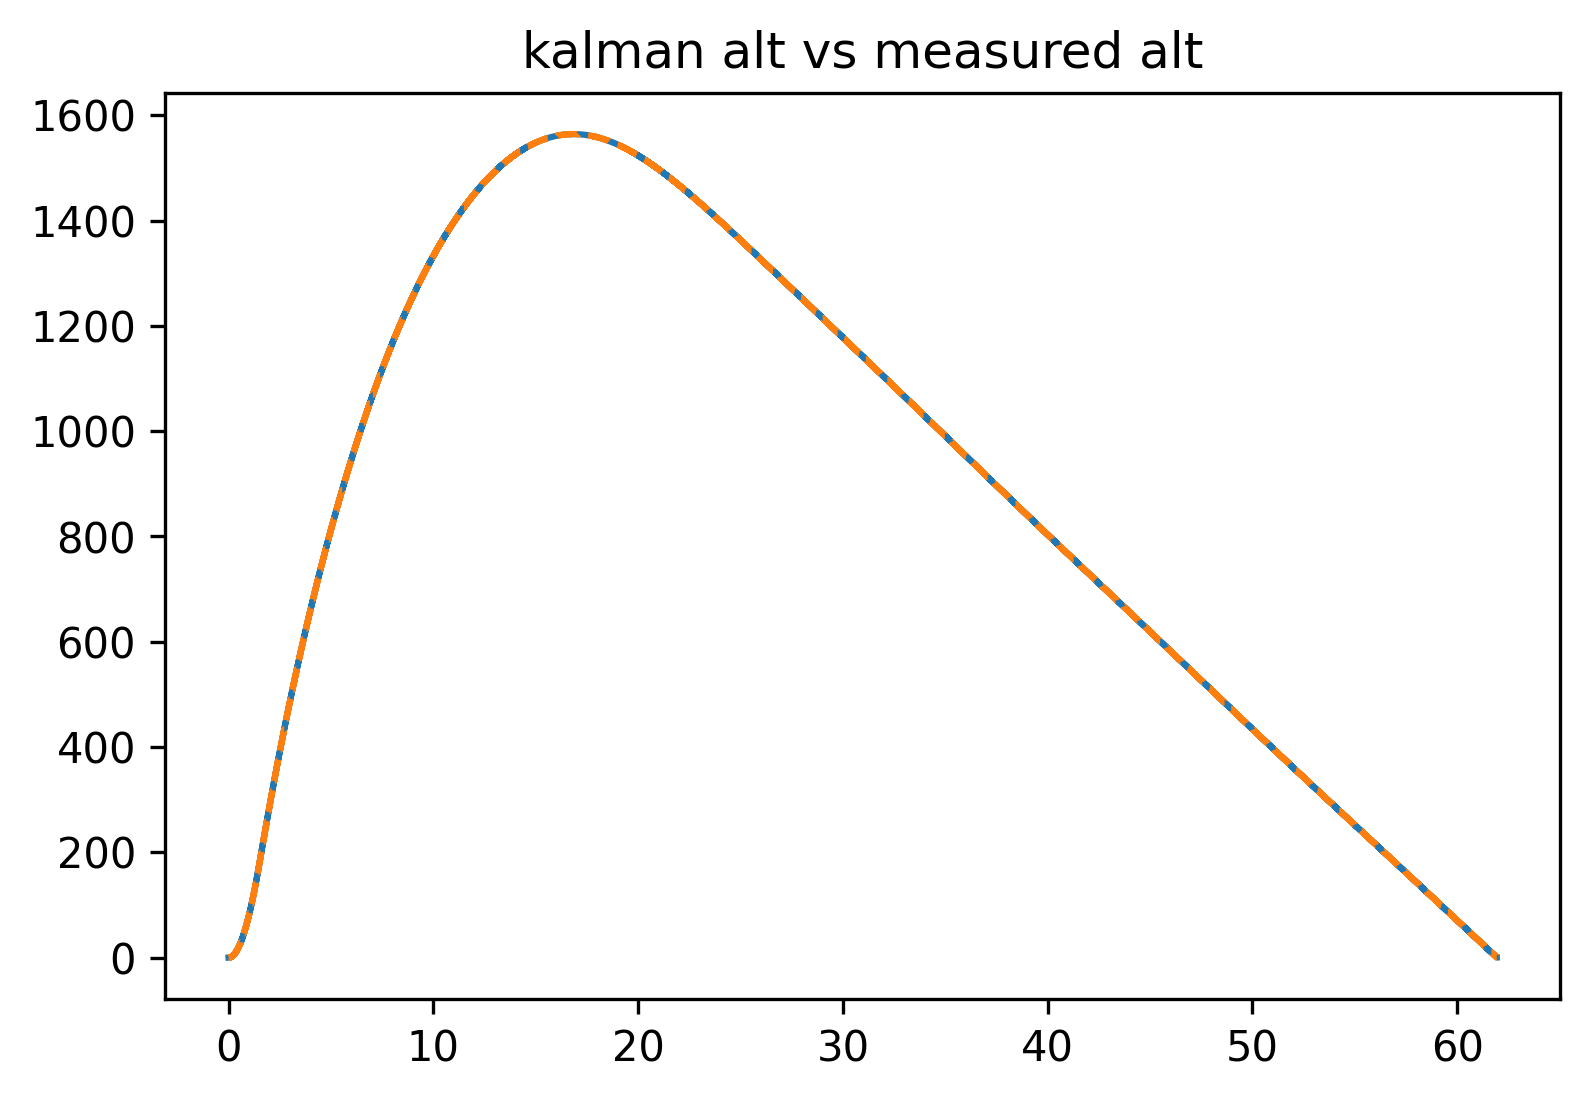

In [113]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,2])
plt.plot(time,measurements[:,0],'--');
plt.title('kalman alt vs measured alt');
plt.gcf().set_facecolor('white')

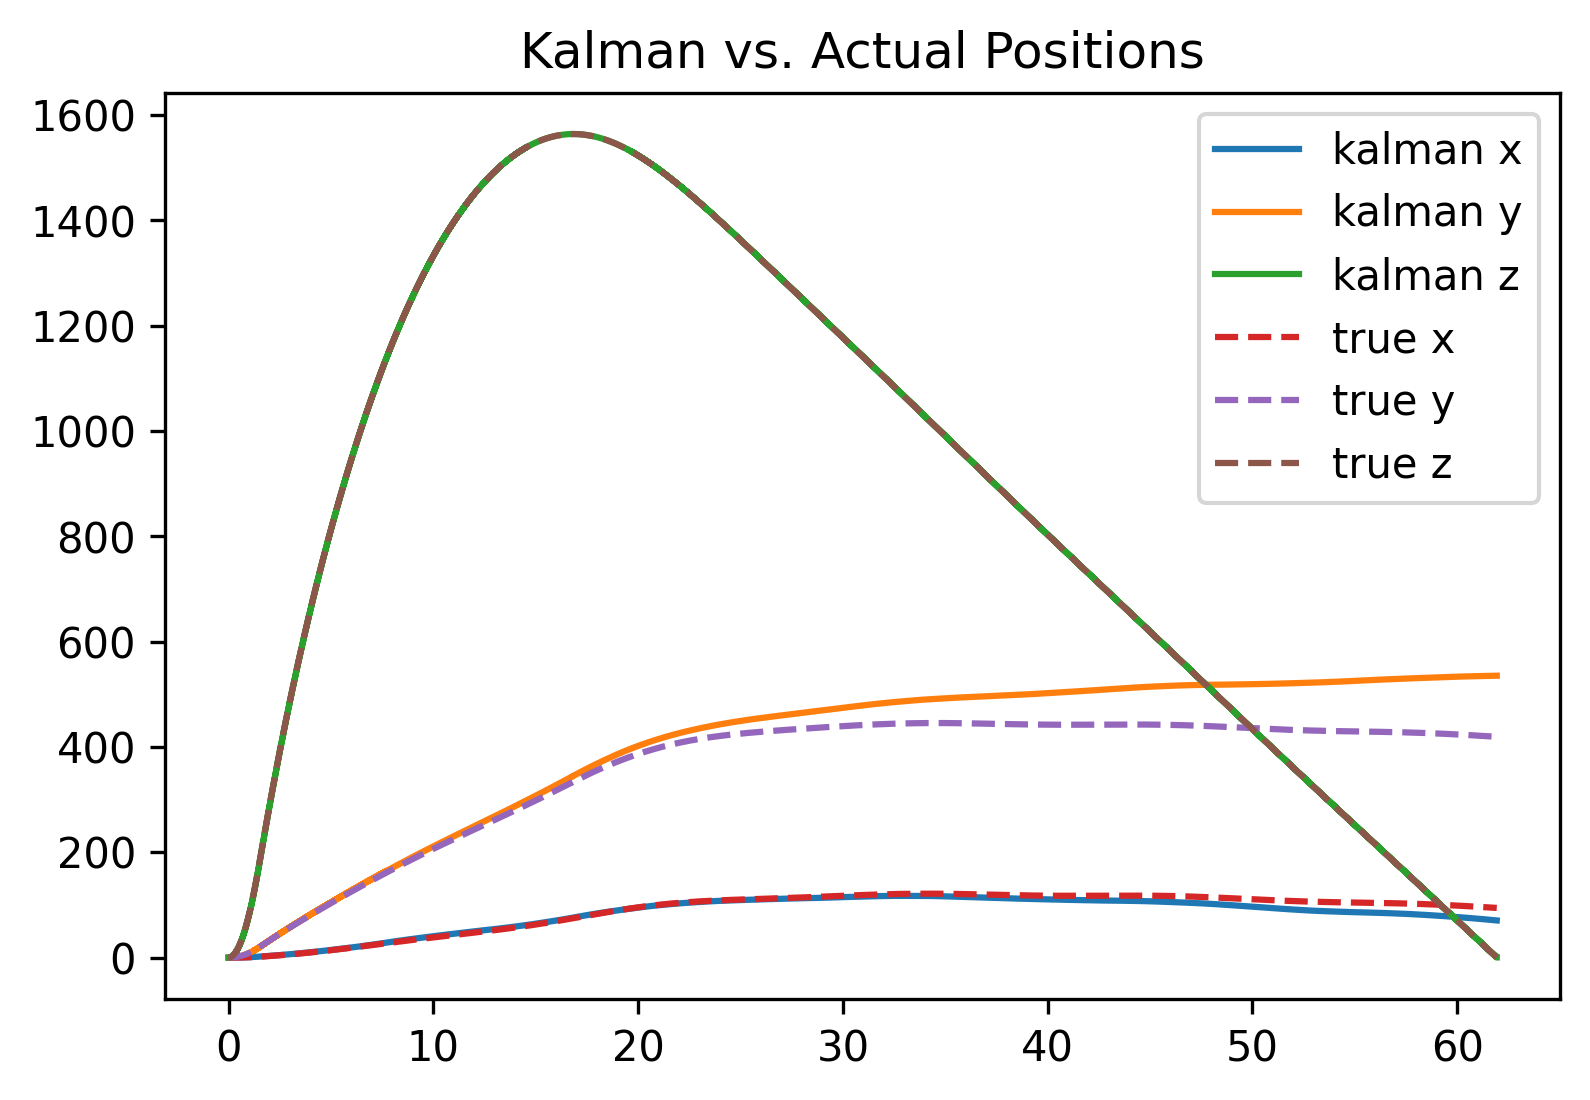

In [114]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,0:3]);
plt.plot(time,positions,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. Actual Positions');
plt.gcf().set_facecolor('white')

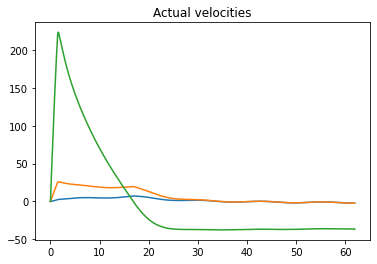

In [115]:
plt.plot(time,velocities);
plt.title('Actual velocities');
plt.gcf().set_facecolor('white')

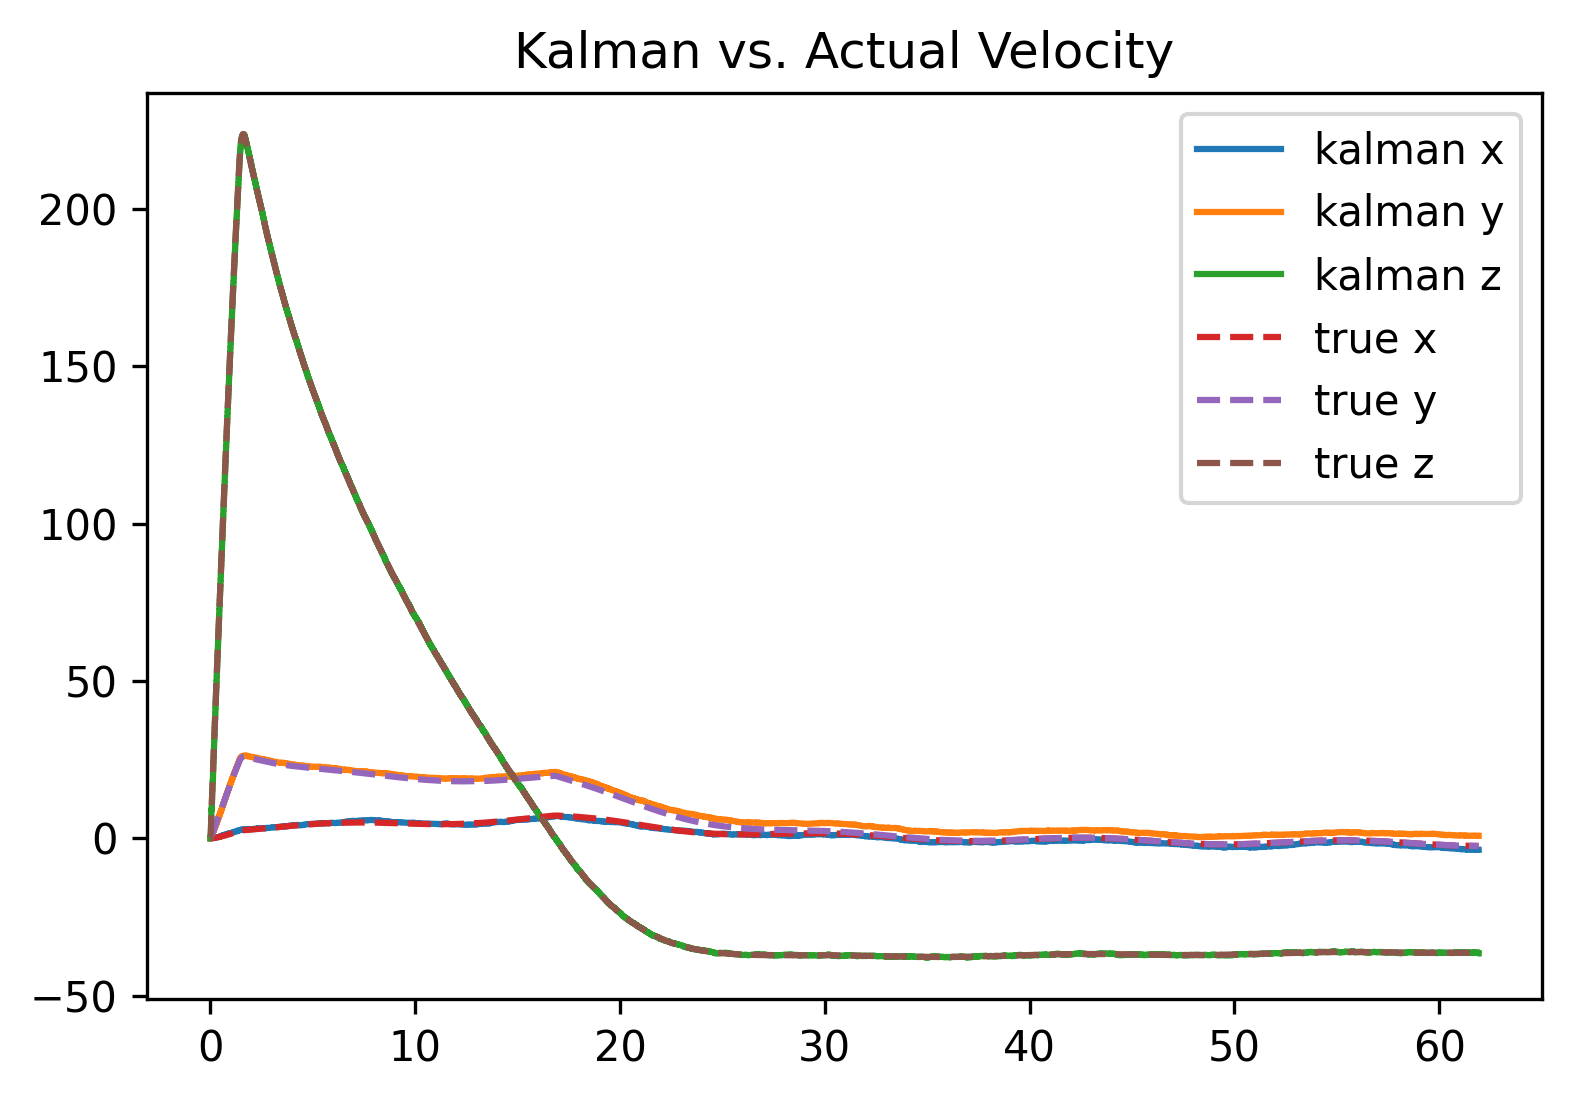

In [116]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,3:6]);
plt.plot(time,velocities,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. Actual Velocity');
plt.gcf().set_facecolor('white')

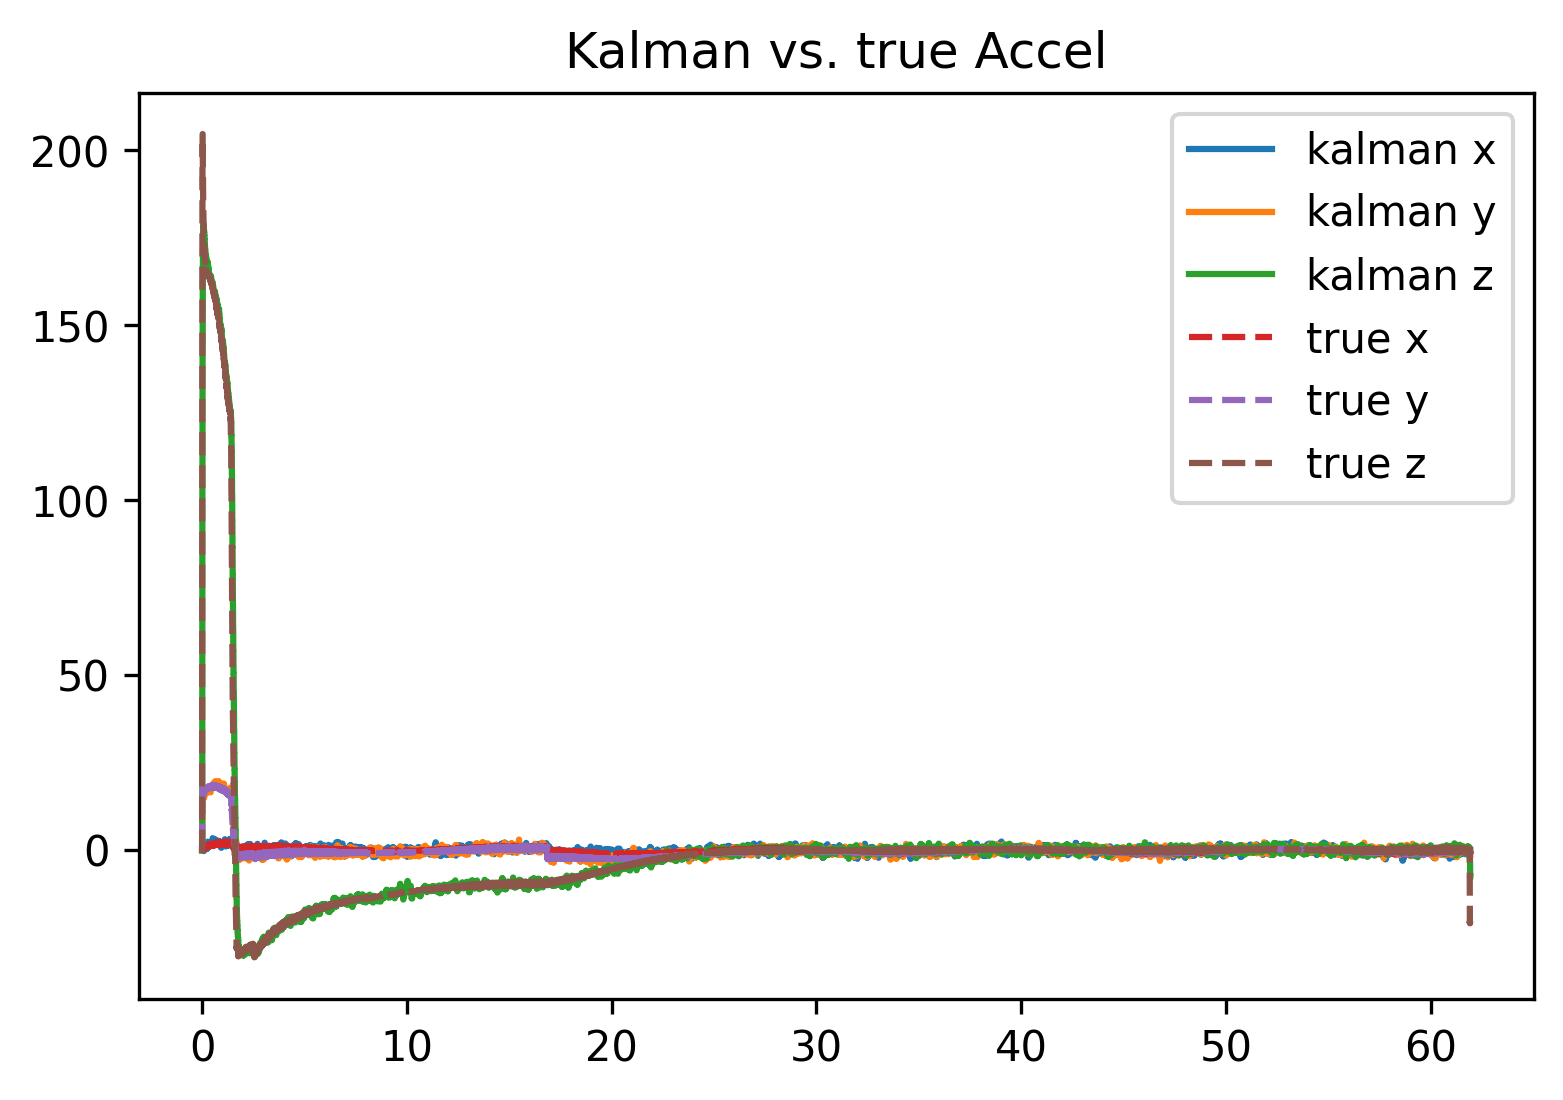

In [117]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, accelerations,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. true Accel');
#plt.xlim([0,10]);
plt.gcf().set_facecolor('white')

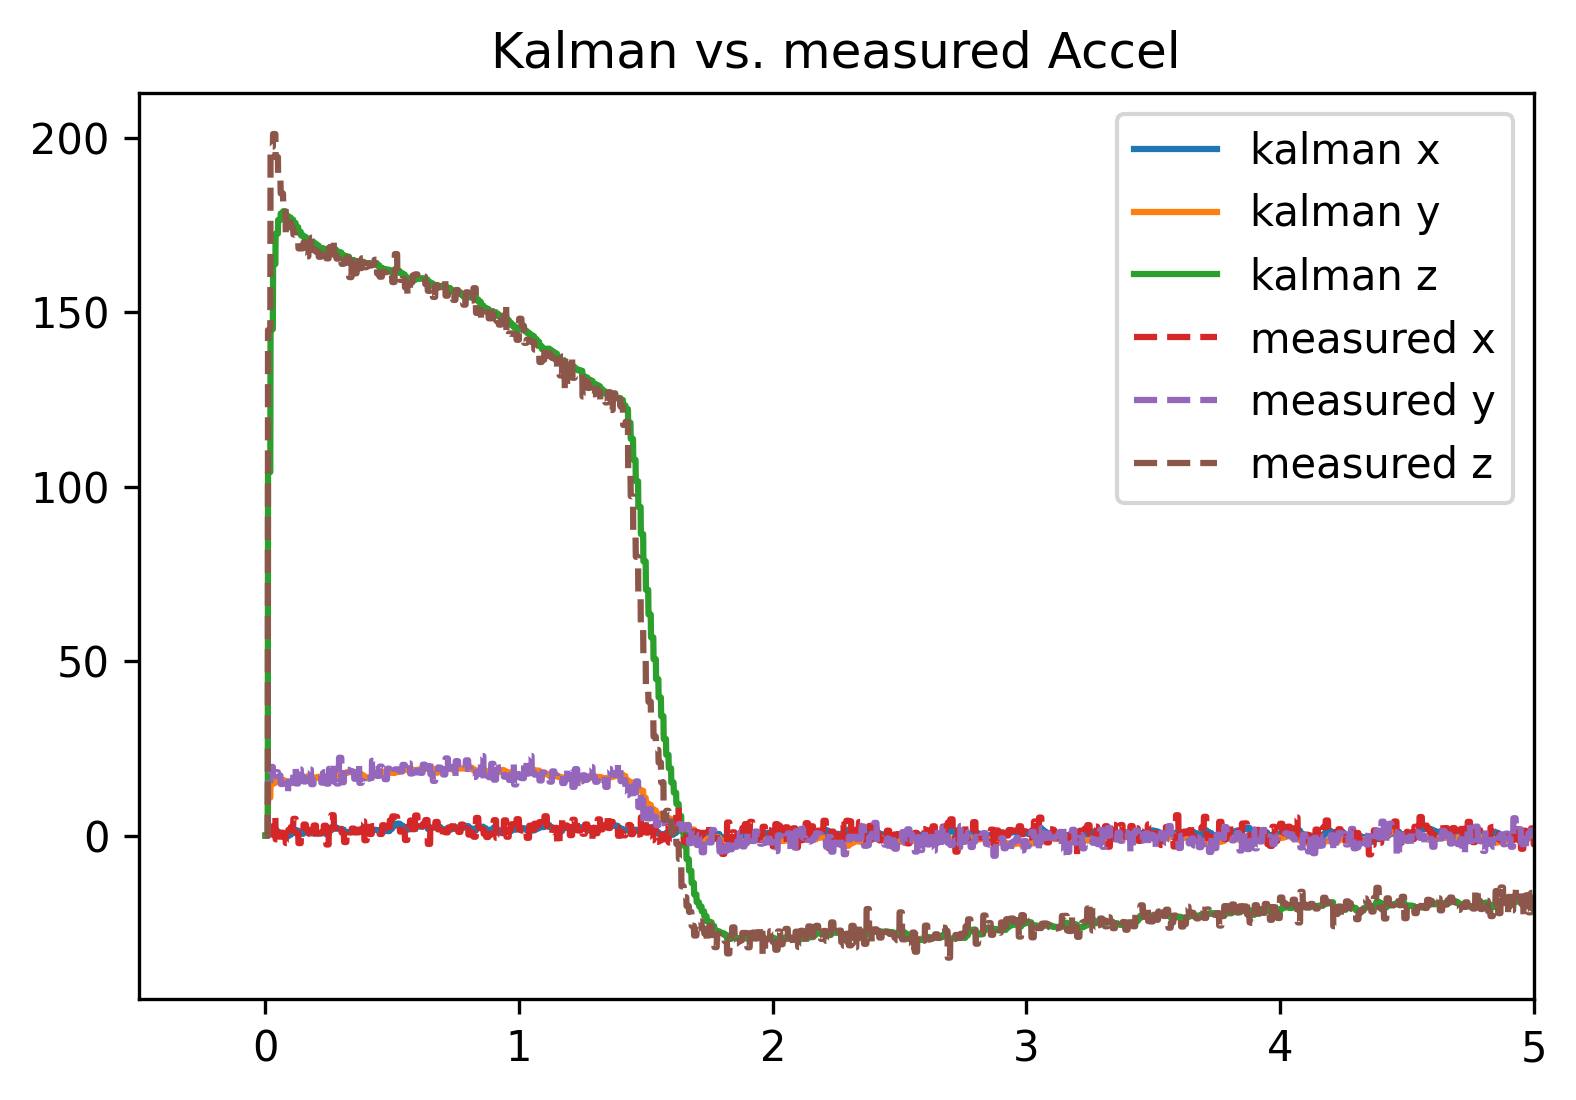

In [118]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, measurements[:,1:4],'--');
plt.legend(['kalman x','kalman y','kalman z','measured x','measured y','measured z'],loc='upper right');
plt.title('Kalman vs. measured Accel');
plt.xlim([-.5,5]);
plt.gcf().set_facecolor('white')

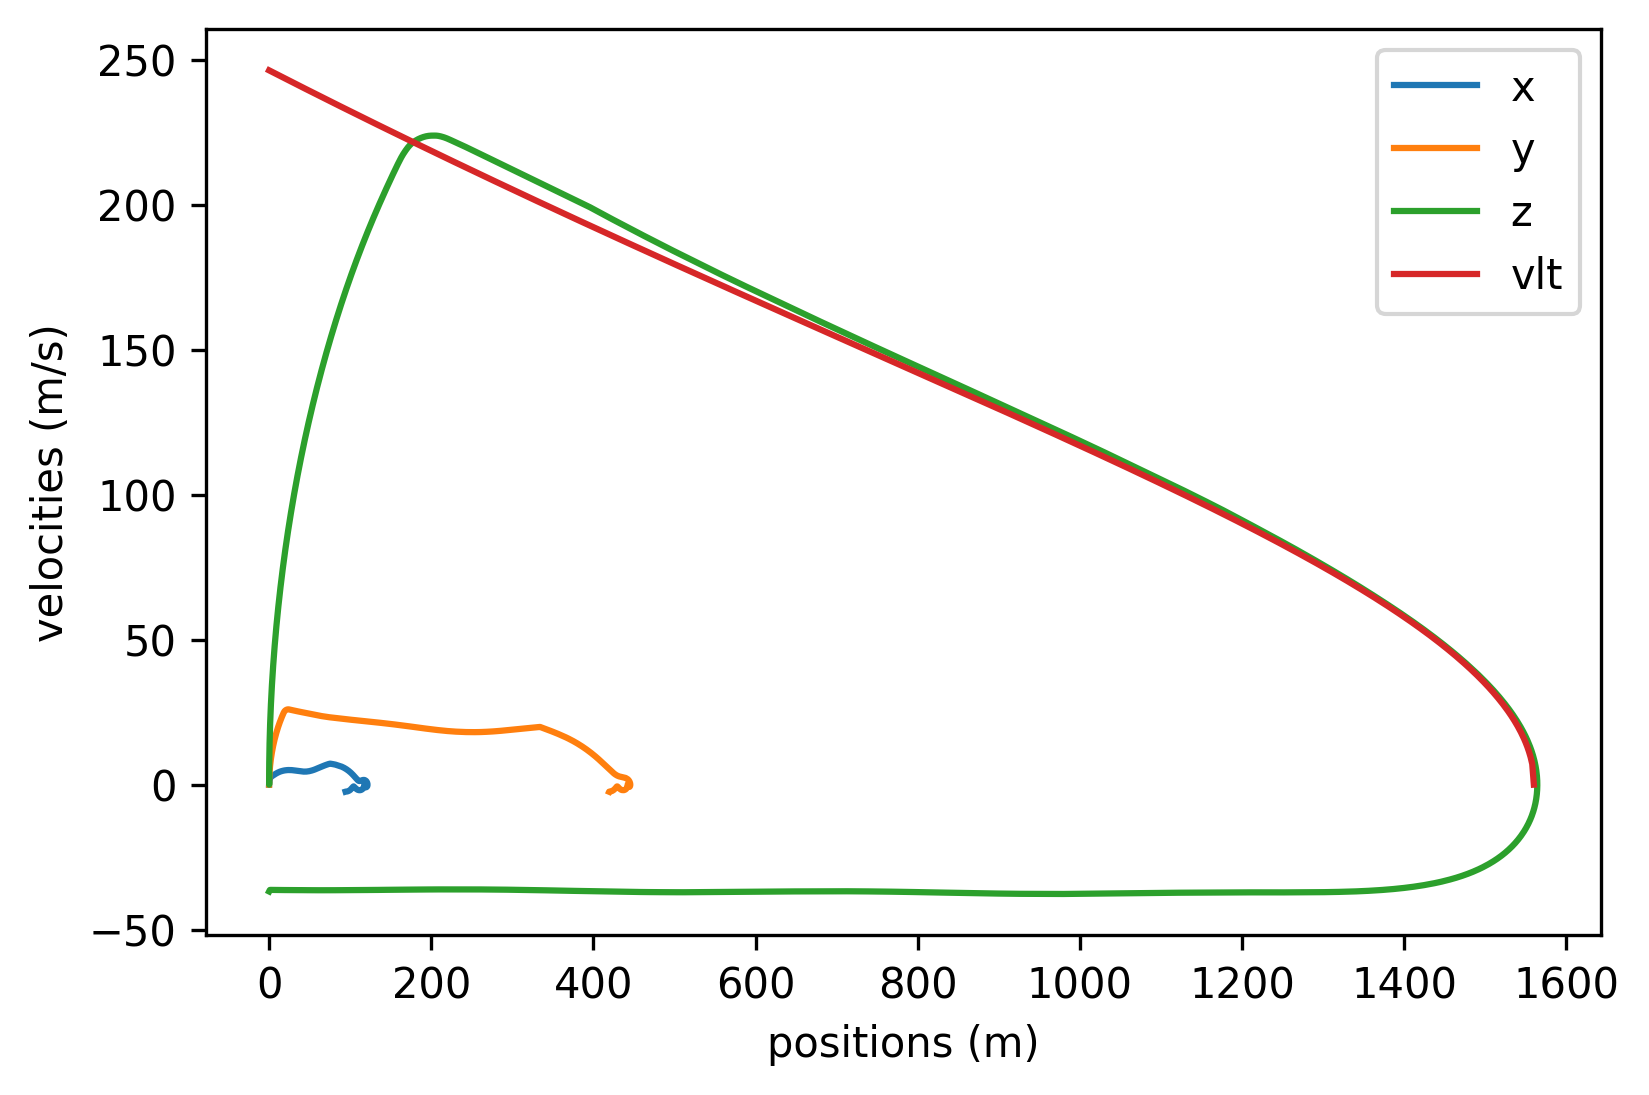

In [119]:
plt.figure(dpi=300)
plt.plot(positions,velocities);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('positions (m)')
plt.ylabel('velocities (m/s)')
plt.legend(['x','y','z','vlt'],loc='upper right');
plt.gcf().set_facecolor('white')

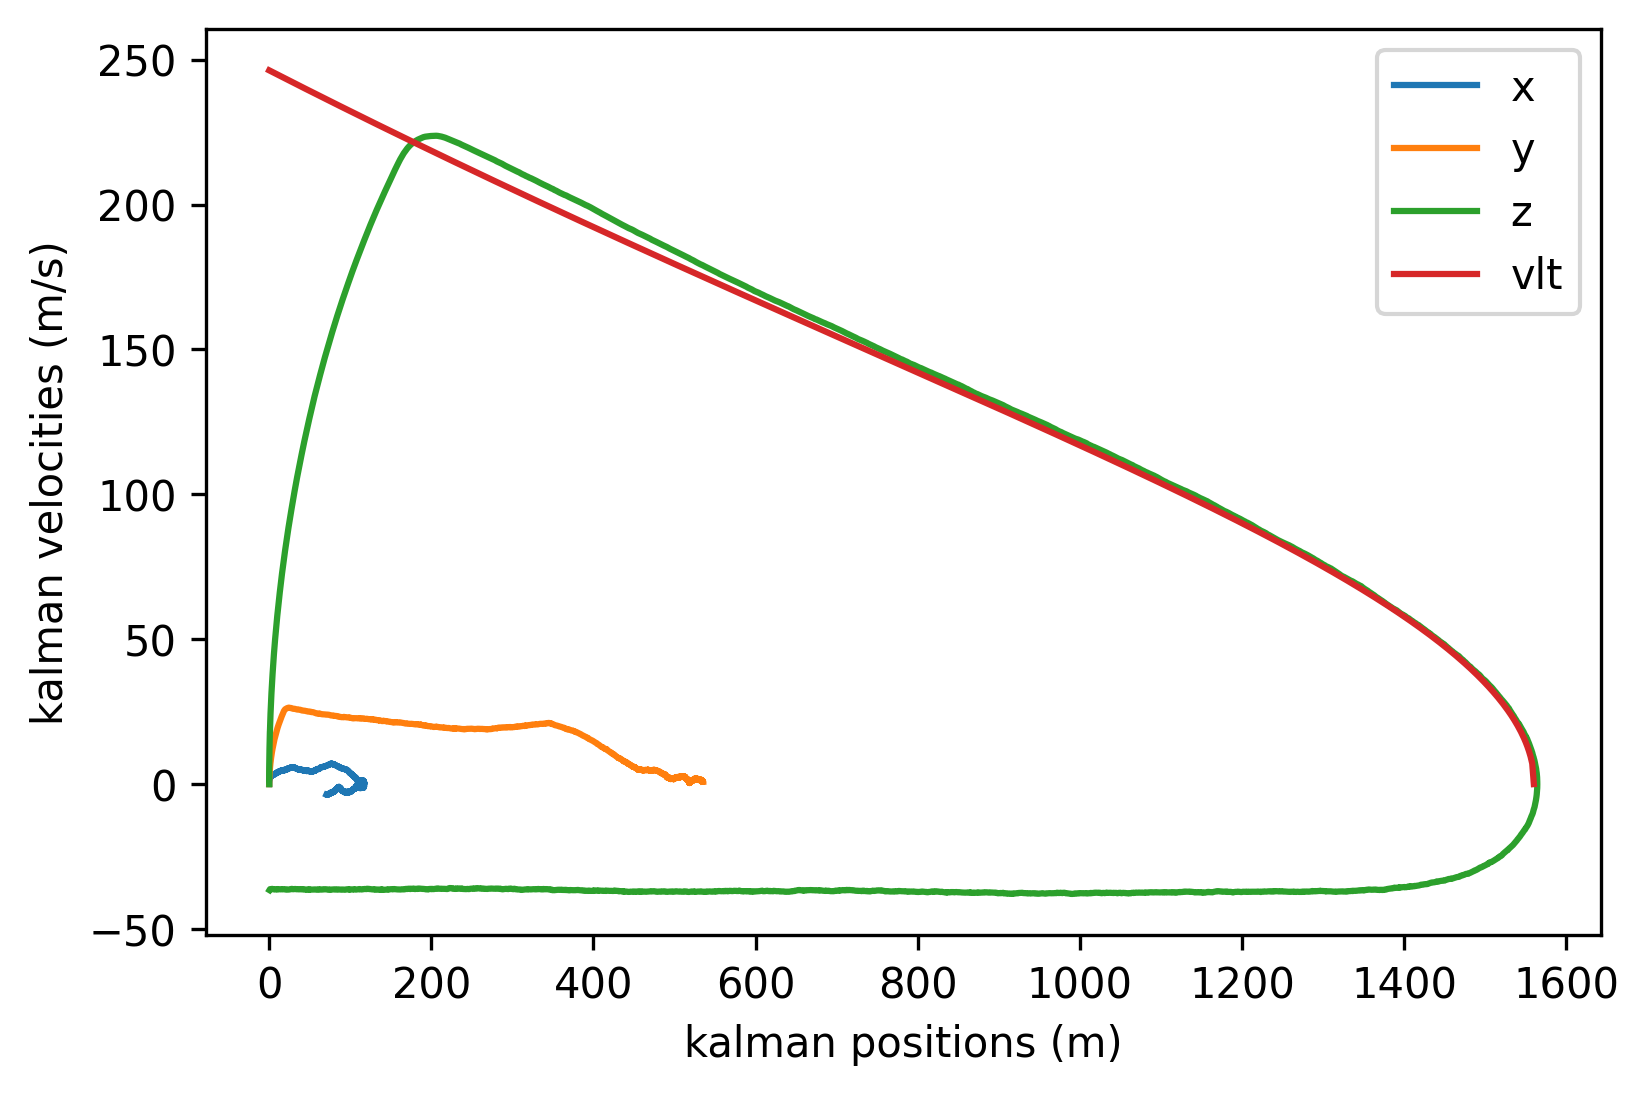

In [120]:
plt.figure(dpi=300)
plt.plot(stateVectors[:,0:3],stateVectors[:,3:6]);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('kalman positions (m)')
plt.ylabel('kalman velocities (m/s)')
plt.legend(['x','y','z','vlt'],loc='upper right');
plt.gcf().set_facecolor('white')

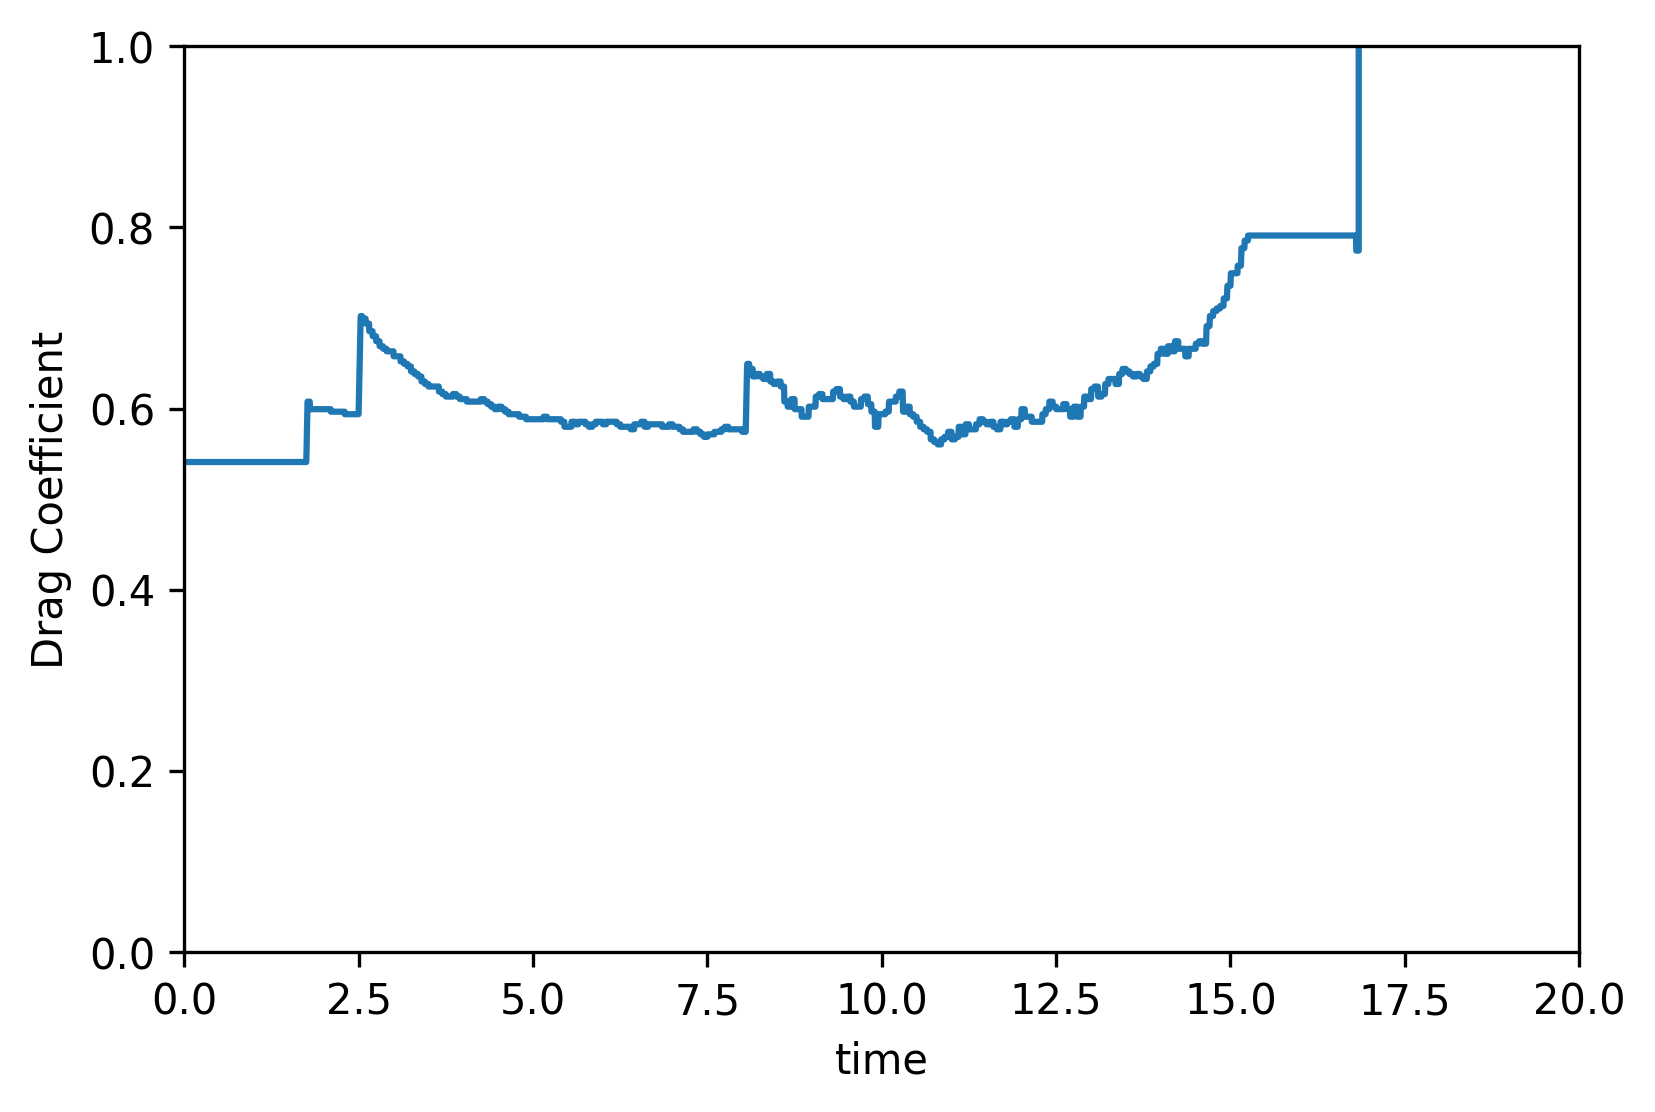

In [121]:
plt.figure(dpi=300)
plt.plot(time,dragCoefficient);
plt.ylim([0,1]);
plt.xlim([0,20]);
plt.xlabel('time')
plt.ylabel('Drag Coefficient');
plt.gcf().set_facecolor('white')

In [122]:
np.max(positions[:,2])

1564.245401659585

In [123]:
np.max(positions[:,2])-targetAlt

3.6694016595849916

In [124]:
PercentError = (np.max(positions[:,2])-targetAlt)/targetAlt*100
PercentError

0.2351312374139415

In [125]:
np.max(velocities[:,2])

223.80591716910882

In [126]:
positions[np.argmax(velocities[:,2]),2]

204.40481093941582

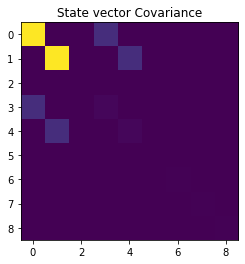

In [127]:
logPkalman = np.sqrt(Pkalman);
logPkalman[np.isneginf(logPkalman)] = 0
plt.imshow(logPkalman);
plt.title('State vector Covariance');